In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.linalg import svd
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [2]:
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq  # Normalized Frequency
    # Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Appling filter
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# FFT function
def compute_fft(signal, sampling_rate):
    N = len(signal)
    yf = fft(signal)
    xf = fftfreq(N, 1 / sampling_rate)[:N // 2]
    return xf, np.abs(yf[:N // 2])

def ssa(signal, window_length):
    N = len(signal)
    # Trajectory matrix
    X = np.array([signal[i:i + window_length] for i in range(N - window_length + 1)])
    
    # Singular values
    U, S, VT = svd(X, full_matrices=False)
    
    return U, S, VT

In [3]:
file = 'xa.s12.00.mhz.1971-05-12HR00_evid00031'

# Reading csv
data_file = f'./data/lunar/training/data/S12_GradeA/{file}.csv'
data_cat = pd.read_csv(data_file)

# Reading catalog
cat_lunar_train_dir = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
cat_lunar_train = pd.read_csv(cat_lunar_train_dir)

# Selecting event "frame"
detection = cat_lunar_train[cat_lunar_train['filename'] == file].iloc[0]['time_rel(sec)']

# Window size
event_window = 3000 * 0.15

# Columns "time_rel(sec)" y "velocity(m/s)"
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

start_time = max(0, detection - event_window)
end_time = min(max(csv_times), detection + event_window)

event_mask = (csv_times >= start_time) & (csv_times <= end_time)
window_times = csv_times[event_mask]
window_data = csv_data[event_mask]

In [4]:
# Filter parameters
highcut = 0.9  
sampling_rate = 1 / 0.15

# Appling filter
filtered_data_low = butter_lowpass_filter(window_data, cutoff=highcut, fs=sampling_rate)

In [5]:
# FFt original signal
xf_original, yf_original = compute_fft(window_data, sampling_rate)

# FFT filtered signal
xf_lowpass, yf_lowpass = compute_fft(filtered_data_low, sampling_rate)

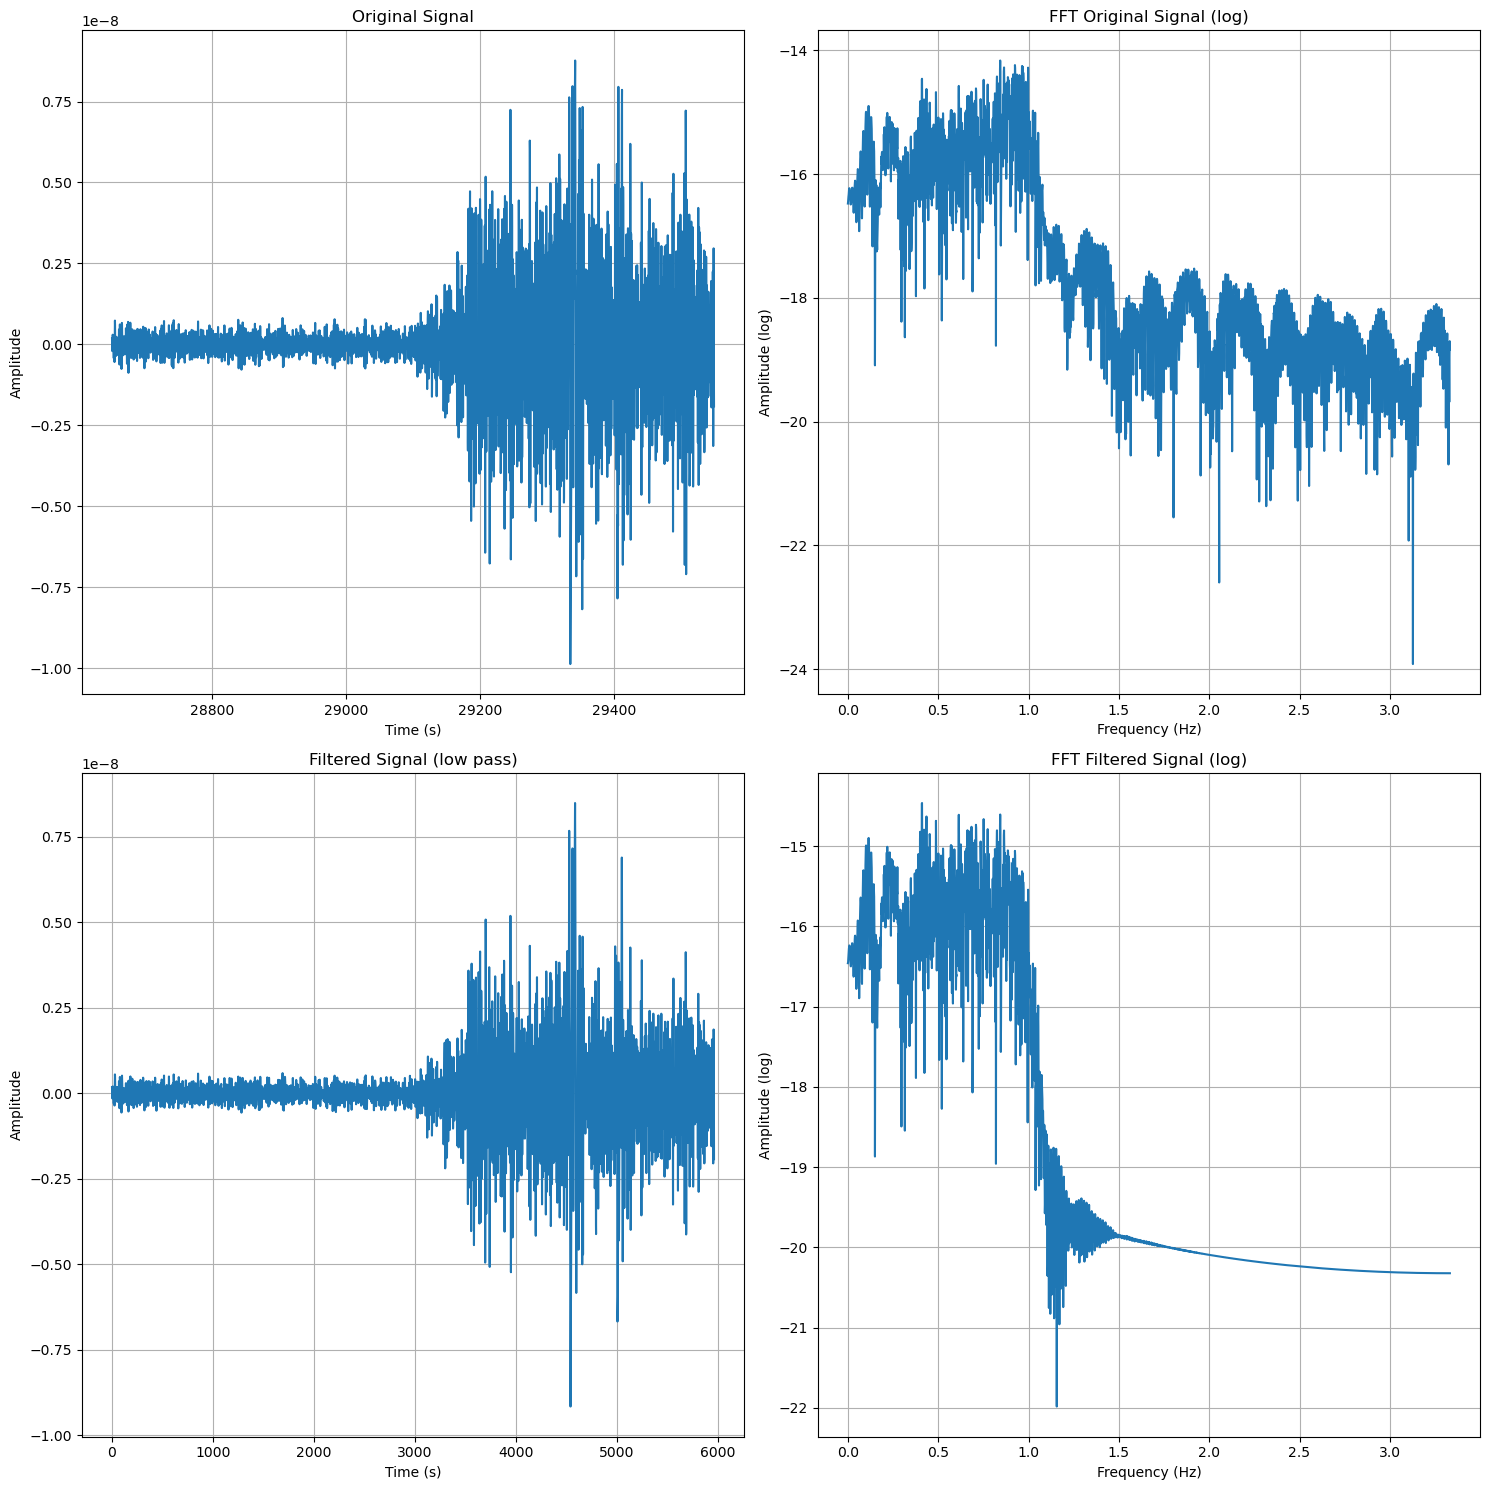

In [12]:
# Visualization
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(window_times, window_data, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(xf_original, np.log(yf_original), label='FFT (Original Signal)')
plt.title('FFT Original Signal (log)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (log)')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(filtered_data_low, label='Filteres Signal (low pass)')
plt.title('Filtered Signal (low pass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(xf_lowpass, np.log(yf_lowpass), label='FFT (Filtered Signal)')
plt.title('FFT Filtered Signal (log)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (log)')
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
# Compute Singular Spectrum Analysis
window_length = 500
U, S, VT = ssa(filtered_data_low, window_length)

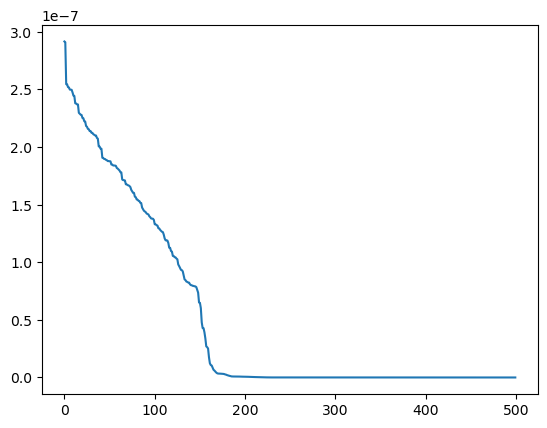

In [8]:
# Plotting singular values
plt.plot(S)
plt.show()

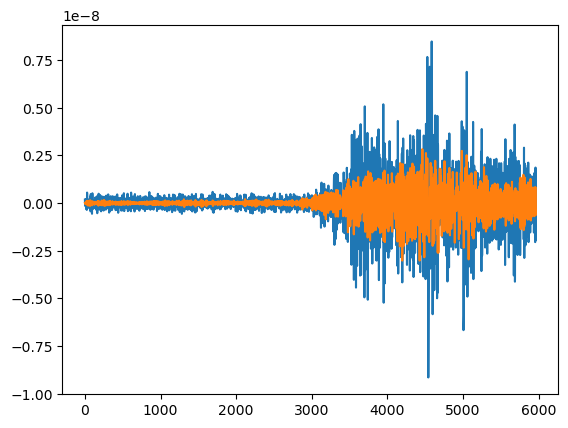

In [9]:
# Reconstructin by 20 principal values
n_components = 20 
reconstructed_trajectory_matrix = np.dot(U[:, :n_components], np.diag(S[:n_components])).dot(VT[:n_components, :])

reconstructed_signal = np.zeros(len(filtered_data_low))
counts = np.zeros(len(filtered_data_low))

for i in range(window_length):
    reconstructed_signal[i: i + len(reconstructed_trajectory_matrix[:, i])] += reconstructed_trajectory_matrix[:, i]
    counts[i: i + len(reconstructed_trajectory_matrix[:, i])] += 1

reconstructed_signal /= counts

plt.plot(filtered_data_low)
plt.plot(reconstructed_signal)
plt.show()

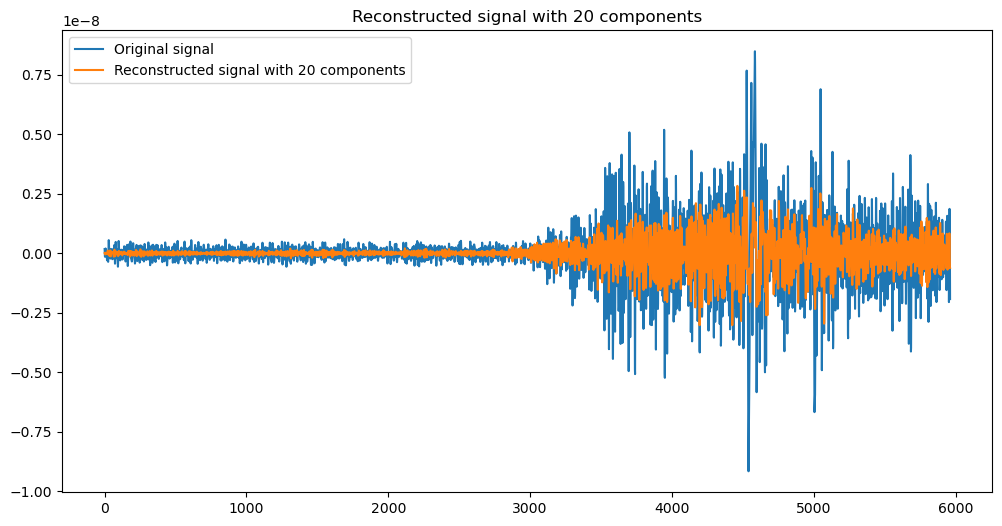

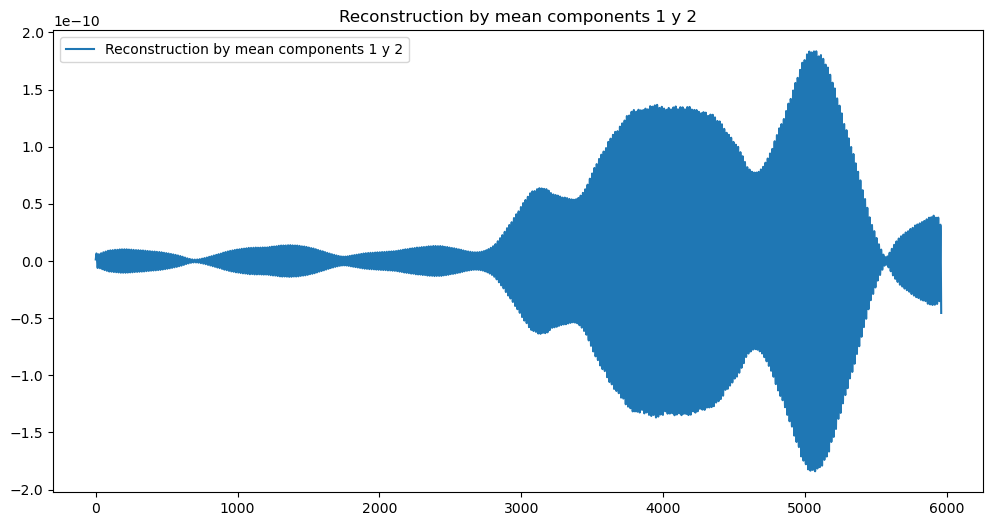

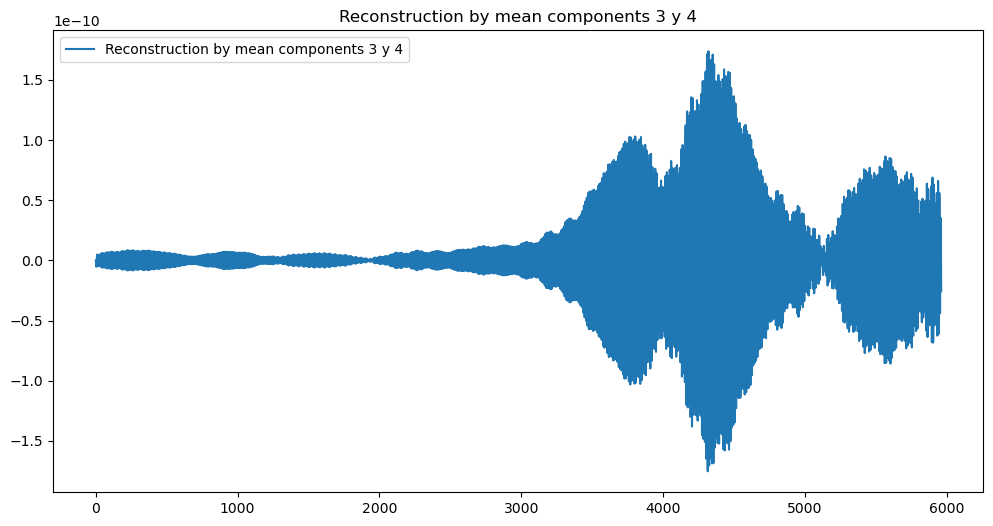

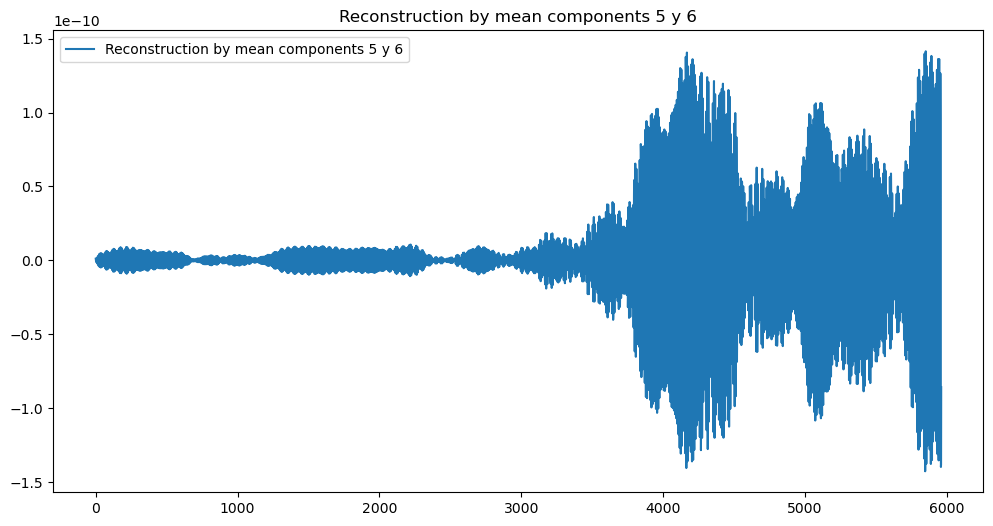

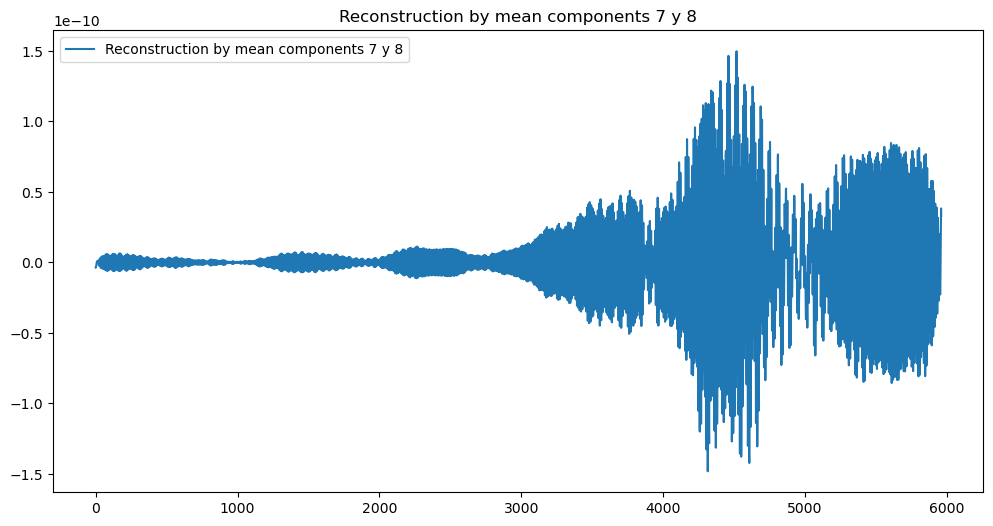

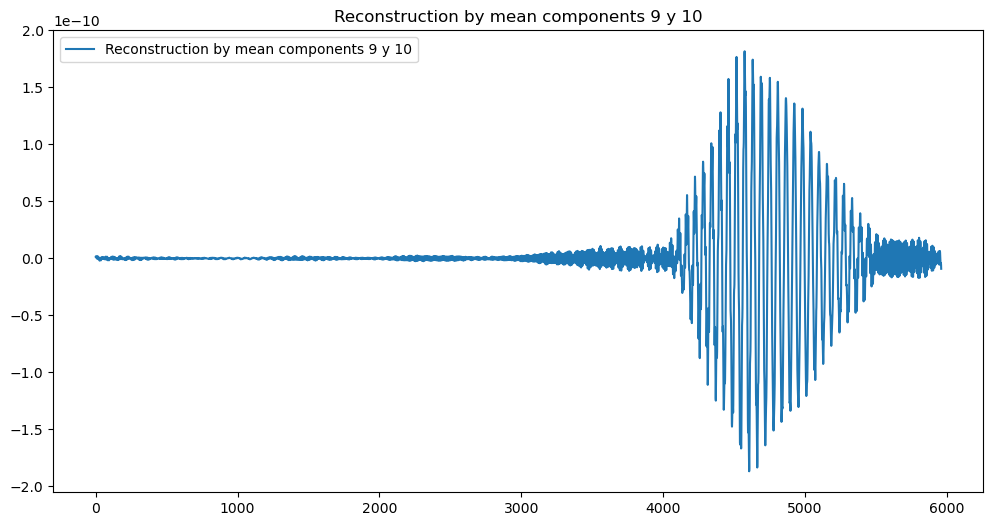

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_data_low, label='Original signal')
plt.plot(reconstructed_signal, label=f'Reconstructed signal with {n_components} components')
plt.title(f'Reconstructed signal with {n_components} components')
plt.legend()
plt.show()

for i in range(0, 10, 2): 
    avg_U = (U[:, i:i+1] + U[:, i+1:i+2]) / 2
    avg_S = (S[i:i+1] + S[i+1:i+2]) / 2
    avg_VT = (VT[i:i+1, :] + VT[i+1:i+2, :]) / 2

    reconstructed_trajectory_matrix_i = np.dot(avg_U, np.diag(avg_S)).dot(avg_VT)

    reconstructed_signal_i = np.zeros(len(filtered_data_low))
    counts_i = np.zeros(len(filtered_data_low))

    for j in range(window_length):
        reconstructed_signal_i[j: j + len(reconstructed_trajectory_matrix_i[:, j])] += reconstructed_trajectory_matrix_i[:, j]
        counts_i[j: j + len(reconstructed_trajectory_matrix_i[:, j])] += 1

    reconstructed_signal_i /= counts_i

    plt.figure(figsize=(12, 6))
    plt.plot(reconstructed_signal_i, label=f'Reconstruction by mean components {i+1} y {i+2}')
    plt.title(f'Reconstruction by mean components {i+1} y {i+2}')
    plt.legend()
    plt.show()

In [15]:
# Reading Catalog
cat_lunar_train_dir = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'
cat_lunar_train = pd.read_csv(cat_lunar_train_dir)

# Parameters
data_dir = './data/lunar/training/data/S12_GradeA/' 
sampling_rate = 1 / 0.15

max = []
min = []

for idx, row in cat_lunar_train.iterrows():
    filename = row['filename']
    arrival_time_rel = row['time_rel(sec)']

    data_file = f"{data_dir}{filename}.csv"
    data_cat = pd.read_csv(data_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    max.append(csv_data.max())
    min.append(csv_data.min())

print("Maximum value of 1D signal: ", np.array(max).max())
print("Minimum value of 1D signal: ",np.array(min).min())

Maximum value of 1D signal:  1.4731434845499466e-07
Minimum value of 1D signal:  -1.4962862873198858e-07
